In [1]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from simulai.utilities.lorenz_solver import lorenz_solver, lorenz_solver_forcing
from simulai.utilities.oscillator_solver import oscillator_solver_forcing
from simulai.regression import OpInf, WeakSINDy, SINDy
from simulai.math.integration import RK4, LSODA, FunctionWrapper, ClassWrapper, RKF78, BRKF78
from simulai.metrics import LyapunovUnits
from simulai.math.basis import UniformTestFunction

from sklearn.preprocessing import PolynomialFeatures
from pysindy import PolynomialLibrary, STLSQ



Global parameters.

In [3]:
dt = 0.002
T_max = 10
rho = 28
beta = 8 / 3
beta_str = '8/3'
sigma = 10
n_field = 3

Generating datasets.

In [4]:
initial_state = np.array([-8, 8, 27])[None, :]
lorenz_data, derivative_lorenz_data, time = lorenz_solver(rho=rho, dt=dt, T=T_max, sigma=sigma,
                                                          initial_state=initial_state,
                                                          beta=beta, beta_str=beta_str,
                                                          data_path='on_memory', solver='RK45')

Performing Collocation Derivation.


In [5]:
from sklearn.metrics import mean_squared_error

def add_noise(data, noise_level=0.0):
    rmse = mean_squared_error(data, np.zeros((data).shape), squared=False)
    return data + np.random.normal(0, rmse * noise_level , data.shape) 

lorenz_data = add_noise(lorenz_data, noise_level=0.2)

Hyperparameters and auxiliary parameters.

In [6]:
t = time
lambda_linear = 1e-3
lambda_quadratic = 1e-3
n_steps = time.shape[0]
nt = int(1 * n_steps)
nt_test = n_steps - nt
t_test = t[nt:]

Separating train and test datasets.

In [7]:
train_field = lorenz_data[:nt]  # manufactured nonlinear oscillator data
train_field_derivatives = derivative_lorenz_data[:nt]

test_field = lorenz_data[nt:]  # manufactured nonlinear oscillator data
test_field_derivatives = derivative_lorenz_data[nt:]

t_train = t[:nt]

Instantiating and executing Operators Inference. This model consists of a quadratic operator as seen below:
$$
\frac{\mathrm{d}\widehat{\mathbf{u}}}{\mathrm{d}t} = \mathbf{A}\widehat{\mathbf{u}} + \mathbf{H}(\widehat{\mathbf{u}} \otimes \widehat{\mathbf{u}}) + \widehat{\mathbf{c}}
$$
In which $\widehat{\mathbf{u}}$ is a ROM generated from the original space $\mathbf{u}$. In case of Lorenz 63 such intermediary transformation is not necessary, so $\widehat{\mathbf{u}} = \mathbf{u}$.

In [8]:
test_function = UniformTestFunction(L=100, overlap=0.7, ghost_cells=0)
basis_function = PolynomialLibrary(degree=2, include_bias=True)
solver = STLSQ(threshold=0.1, alpha=1e-14, max_iter=20)
solver = 'lstsq'
lorenz_op = SINDy(solver=solver, feature_library=basis_function)
#lorenz_op.set(lambda_linear=lambda_linear, lambda_quadratic=lambda_quadratic)
lorenz_op.fit(train_field, t_train)

/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/simulai/regression/_sindy.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(self.G, self.b)[0]


array([-48.47334919,   0.32052506,   6.17030416,   3.85820531,
         0.60531869,  -1.0657839 ,  -0.11285216,   0.51314605,
        -0.09741065,  -0.10169274,  31.0425552 ,   5.25192191,
        13.52161532,  -2.93023625,   0.05306368,  -0.23115707,
        -0.23698493,   0.1491343 ,  -0.52169489,   0.06126613,
        30.79150844,  -2.83814382,   2.47791803,  -7.11847076,
        -0.62167364,   0.99911284,   0.11658602,   0.19958085,
        -0.09798471,   0.15478247])

In [9]:

estimated_field_derivatives = lorenz_op.eval(train_field)
tags = ['x', 'y', 'z']

Visualizing time-derivatives.

In [10]:
test_field_derivatives.shape

(0, 3)

In [11]:
estimated_field_derivatives.shape

(5001, 3)

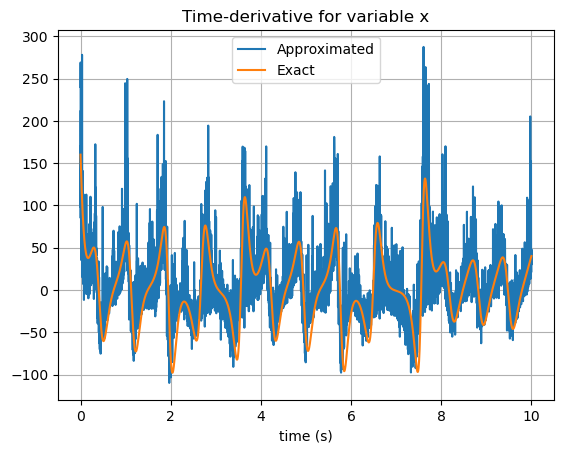

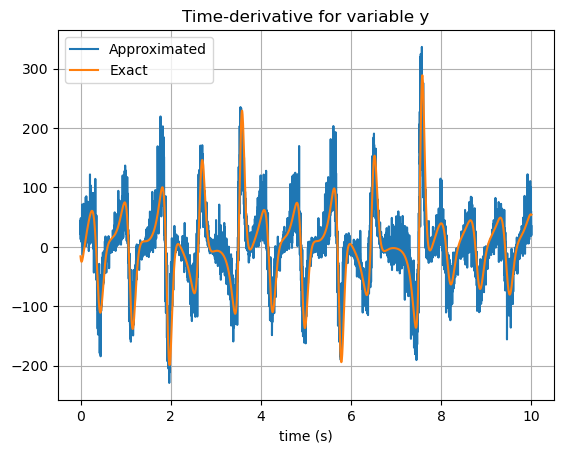

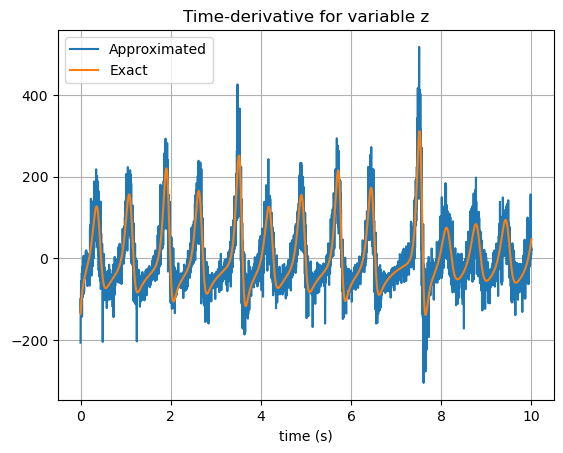

In [12]:
for var in range(n_field):
    plt.title(f"Time-derivative for variable {tags[var]}")

    plt.plot(t_train, estimated_field_derivatives[:, var], label="Approximated")
    plt.plot(t_train, train_field_derivatives[:, var], label="Exact")
    plt.xlabel("time (s)")
    plt.legend()
    plt.grid(True)
    plt.show()

Construcing jacobian tensor (It could be used during the time-integrations, but seemingly it is not).

In [13]:
#lorenz_op.construct_K_op()

Time-integrating the trained model and visualizing the output.

In [14]:
# Using the derivatives surrogate for time-integrating
right_operator = ClassWrapper(lorenz_op)

solver = BRKF78(right_operator)

initial_state = train_field[0]

estimated_field = solver.run(initial_state, t_train)

Estimating the number of Lyapunov units for the extrapolation.

In [15]:
#lyapunov_estimator = LyapunovUnits(lyapunov_unit=0.96, tol=0.001, time_scale=dt)
#n_units = lyapunov_estimator(data=estimated_field[:], reference_data=test_field, relative_norm=True)
#print(f"Number of Lyapunov units extrapolated: {n_units}")

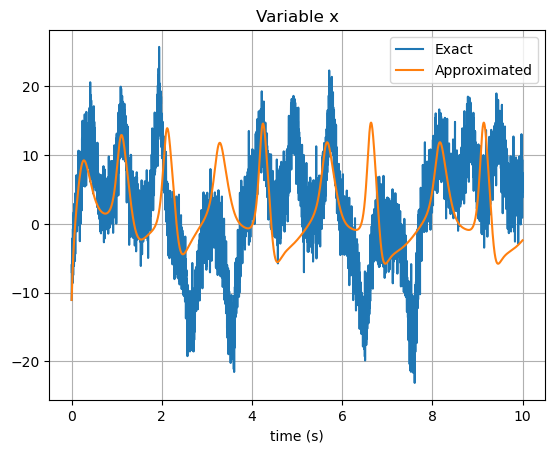

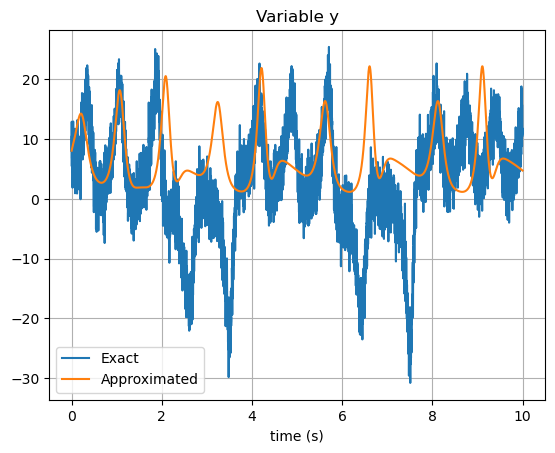

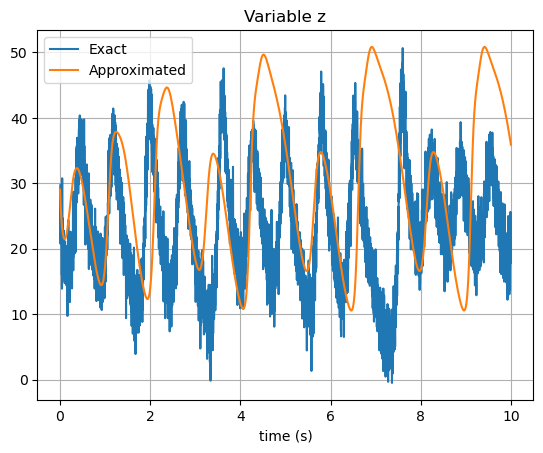

In [16]:
for var in range(n_field):
   plt.title(f"Variable {tags[var]}")
   plt.plot(t_train, train_field[:, var], label="Exact")
   plt.plot(t_train, estimated_field[:, var], label="Approximated")
   plt.xlabel("time (s)")
   plt.grid(True)
   plt.legend()
   plt.show()